## 1. Import Libraries dan Setup

In [ ]:
%pip install seaborn spacy matplotlib pandas numpy
%pip install spacy
!python -m spacy download en_core_web_sm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter, defaultdict
import warnings
warnings.filterwarnings('ignore')

import spacy

try:
    nlp = spacy.load("en_core_web_sm")
    print("Model spaCy berhasil dimuat!")
except OSError:
    print("Silakan install model spaCy bahasa Inggris: python -m spacy download en_core_web_sm")
    nlp = None

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     - -------------------------------------- 0.5/12.8 MB 2.8 MB/s eta 0:00:05
     --- ------------------------------------ 1.0/12.8 MB 3.1 MB/s eta 0:00:04
     ---- ----------------------------------- 1.6/12.8 MB 2.8 MB/s eta 0:00:05
     ------- -------------------------------- 2.4/12.8 MB 2.7 MB/s eta 0:00:04
     -------- ------------------------------- 2.6/12.8 MB 2.5 MB/s eta 0:00:05
     --------- ------------------------------ 3.1/12.8 MB 2.4 MB/s eta 0:00:05
     ----------- ---------------------------- 3.7/12.8 MB 2.5 MB/s eta 0:00:04
     ------------- -------------------------- 4.2/12.8 MB 2.6 MB/s eta 0:00:04
     -------------- ------------------------- 4.7/12.8 MB 2.6 MB/s eta 0:00:04
     ---------------- ----------------------- 5.2/12.8 MB 2.5 MB/s eta 0:00:04
     

## 2. Load dan Eksplorasi Data

In [ ]:
df = pd.read_csv('Macron.csv')

print(f"Dimensi dataset: {df.shape}")
print(f"Kolom: {df.columns.tolist()}")
print("\n5 baris pertama:")
df.head()

Dimensi dataset: (113, 15)
Kolom: ['conversation_id_str', 'created_at', 'favorite_count', 'full_text', 'id_str', 'image_url', 'in_reply_to_screen_name', 'lang', 'location', 'quote_count', 'reply_count', 'retweet_count', 'tweet_url', 'user_id_str', 'username']

5 baris pertama:


,conversation_id_str,created_at,favorite_count,full_text,id_str,image_url,in_reply_to_screen_name,lang,location,quote_count,reply_count,retweet_count,tweet_url,user_id_str,username
0,1927014169628332456,Mon May 26 14:49:14 +0000 2025,10490,People will get lots of jokes off about Macron...,1927014169628332456,https://pbs.twimg.com/amplify_video_thumb/1927...,NaN,en,NaN,209,1250,1739,https://x.com/undefined/status/192701416962833...,16523905,NaN
1,1927032590617178229,Mon May 26 16:02:26 +0000 2025,3443,Amerix: Don't marry a woman older than you. It...,1927032590617178229,https://pbs.twimg.com/amplify_video_thumb/1927...,NaN,en,NaN,30,236,711,https://x.com/undefined/status/192703259061717...,34908371,NaN
2,1927005461259161837,Mon May 26 14:14:38 +0000 2025,52709,Macron was 15. His teacher Brigette was 40 and...,1927005461259161837,https://pbs.twimg.com/media/Gr4ZC8FWsAA8-xQ.jpg,NaN,en,NaN,524,1350,7361,https://x.com/undefined/status/192700546125916...,1552795969959636992,NaN
3,1926991882384466011,Mon May 26 13:20:41 +0000 2025,5983,Macron's office claims that it was a moment of...,1926991882384466011,https://pbs.twimg.com/amplify_video_thumb/1926...,NaN,en,NaN,102,753,1025,https://x.com/undefined/status/192699188238446...,1355721251180961792,NaN
4,1927038560026161219,Mon May 26 16:26:10 +0000 2025,5241,The puppet president of France Emmanuel Macron...,1927038560026161219,https://pbs.twimg.com/amplify_video_thumb/1927...,NaN,en,NaN,133,603,1168,https://x.com/undefined/status/192703856002616...,109065990,NaN


In [ ]:
texts = df['full_text'].dropna().tolist()
print(f"Total tweet: {len(texts)}")
print(f"Contoh teks: {texts[0][:200]}...")

Total tweet: 113
Contoh teks: People will get lots of jokes off about Macron getting slapped by his wife but real talk: If you re in a relationship where someone puts hands on you LEAVE. It s not normal and there s no excuse for i...


## 3. Text Preprocessing

In [ ]:
def preprocess_text(text):
    """
    Preprocessing teks untuk analisis POS tagging
    """
    text = text.lower()

    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#(\w+)', r'\1', text)

    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\w\s\.\!\?\,\;\:]', '', text)

    text = text.strip()
    
    return text

preprocessed_texts = [preprocess_text(text) for text in texts]

preprocessed_texts = [text for text in preprocessed_texts if text.strip()]

print(f"Teks setelah preprocessing: {len(preprocessed_texts)}")
print(f"Contoh teks yang telah diproses: {preprocessed_texts[0][:200]}...")

Teks setelah preprocessing: 113
Contoh teks yang telah diproses: people will get lots of jokes off about macron getting slapped by his wife but real talk: if you re in a relationship where someone puts hands on you leave. it s not normal and there s no excuse for i...


## 4. POS Tagging dengan spaCy

In [ ]:
def pos_tag_text_spacy(text):
    """
    Melakukan POS tagging menggunakan spaCy
    """
    if nlp is None:
        return []
    
    doc = nlp(text)
    
    pos_results = []
    for sent in doc.sents:
        words = [token.text for token in sent]
        pos_tags = [(token.text, token.pos_) for token in sent]
        detailed_tags = [(token.text, token.tag_) for token in sent]
        pos_results.append({
            'sentence': sent.text,
            'words': words,
            'pos_tags': pos_tags,
            'detailed_tags': detailed_tags
        })
    
    return pos_results

spacy_pos_results = []
if nlp is not None:
    for text in preprocessed_texts[:20]:
        result = pos_tag_text_spacy(text)
        spacy_pos_results.extend(result)
    print(f"Kalimat yang diproses dengan spaCy: {len(spacy_pos_results)}")
else:
    print("spaCy tidak tersedia")

Kalimat yang diproses dengan spaCy: 52


## 5. Visualisasi Hasil POS Tagging (10 Kalimat)

In [71]:
def create_pos_table(pos_results, max_sentences=10):
    """
    Membuat tabel detail hasil POS tagging
    """
    table_data = []
    
    for i, result in enumerate(pos_results[:max_sentences]):
        sentence = result['sentence'][:100] + '...' if len(result['sentence']) > 100 else result['sentence']

        pos_string = ' | '.join([f"{word}({tag})" for word, tag in result['pos_tags'][:15]])
        if len(result['pos_tags']) > 15:
            pos_string += ' | ...'
        
        table_data.append({
            'No': i+1,
            'Kalimat': sentence,
            'Tag POS': pos_string,
            'Jumlah Kata': len(result['words'])
        })
    
    df_table = pd.DataFrame(table_data)
    return df_table

if spacy_pos_results:
    print("=== Hasil POS Tagging spaCy (10 Kalimat) ===")
    spacy_table = create_pos_table(spacy_pos_results)
    display(spacy_table)

else:
    print("Tidak ada hasil spaCy yang tersedia")

=== Hasil POS Tagging spaCy (10 Kalimat) ===


,No,Kalimat,Tag POS,Jumlah Kata
0,1,people will get lots of jokes off about macron...,people(NOUN) | will(AUX) | get(VERB) | lots(NO...,32
1,2,it s not normal and there s no excuse for it.,it(PRON) | s(VERB) | not(PART) | normal(ADJ) |...,12
2,3,people who love and respect you don t hit you.,people(NOUN) | who(PRON) | love(VERB) | and(CC...,11
3,4,amerix: dont marry a woman older than you.,amerix(PROPN) | :(PUNCT) | do(AUX) | nt(PART) ...,11
4,5,it might look exciting at first but in the lon...,it(PRON) | might(AUX) | look(VERB) | exciting(...,16
5,6,soymen and simps: tell that to macron he will ...,soymen(NOUN) | and(CCONJ) | simps(NOUN) | :(PU...,14
6,7,macron:,macron(PROPN) | :(PUNCT),2
7,8,macron was 15.,macron(NOUN) | was(AUX) | 15(NUM) | .(PUNCT),4
8,9,his teacher brigette was 40 and married with a...,his(PRON) | teacher(NOUN) | brigette(NOUN) | w...,13
9,10,the slap is merely a minuscule tip of that ice...,the(DET) | slap(NOUN) | is(AUX) | merely(ADV) ...,11


## 6. Analisis Frekuensi Jenis Kata

In [ ]:
def analyze_pos_frequency_spacy(texts, max_texts=100):
    """
    Menganalisis frekuensi tag POS menggunakan spaCy
    """
    if nlp is None:
        return {}
    
    spacy_pos_counter = Counter()
    spacy_detailed_counter = Counter()
    
    for text in texts[:max_texts]:
        doc = nlp(text)
        for token in doc:
            if not token.is_punct and not token.is_space:
                spacy_pos_counter[token.pos_] += 1
                spacy_detailed_counter[token.tag_] += 1
    
    return {
        'spacy_pos': spacy_pos_counter,
        'spacy_detailed': spacy_detailed_counter
    }

pos_analysis = analyze_pos_frequency_spacy(preprocessed_texts)

if pos_analysis:
    print("=== Frekuensi Tag POS spaCy (Kategori Umum) ===")
    for tag, count in pos_analysis['spacy_pos'].most_common(10):
        print(f"{tag}: {count}")
    
    print("\n=== Frekuensi Tag POS spaCy (Detail) ===")
    for tag, count in pos_analysis['spacy_detailed'].most_common(10):
        print(f"{tag}: {count}")
else:
    print("Tidak ada hasil analisis yang tersedia")

=== Frekuensi Tag POS spaCy (Kategori Umum) ===
NOUN: 519
VERB: 307
PRON: 250
ADP: 237
PROPN: 210
DET: 180
AUX: 144
ADJ: 143
ADV: 79
SCONJ: 62

=== Frekuensi Tag POS spaCy (Detail) ===
NN: 460
IN: 270
NNP: 209
DT: 198
JJ: 137
PRP: 122
VBZ: 119
VBD: 88
RB: 87
PRP$: 72


## 7. Visualisasi Distribusi POS Tags

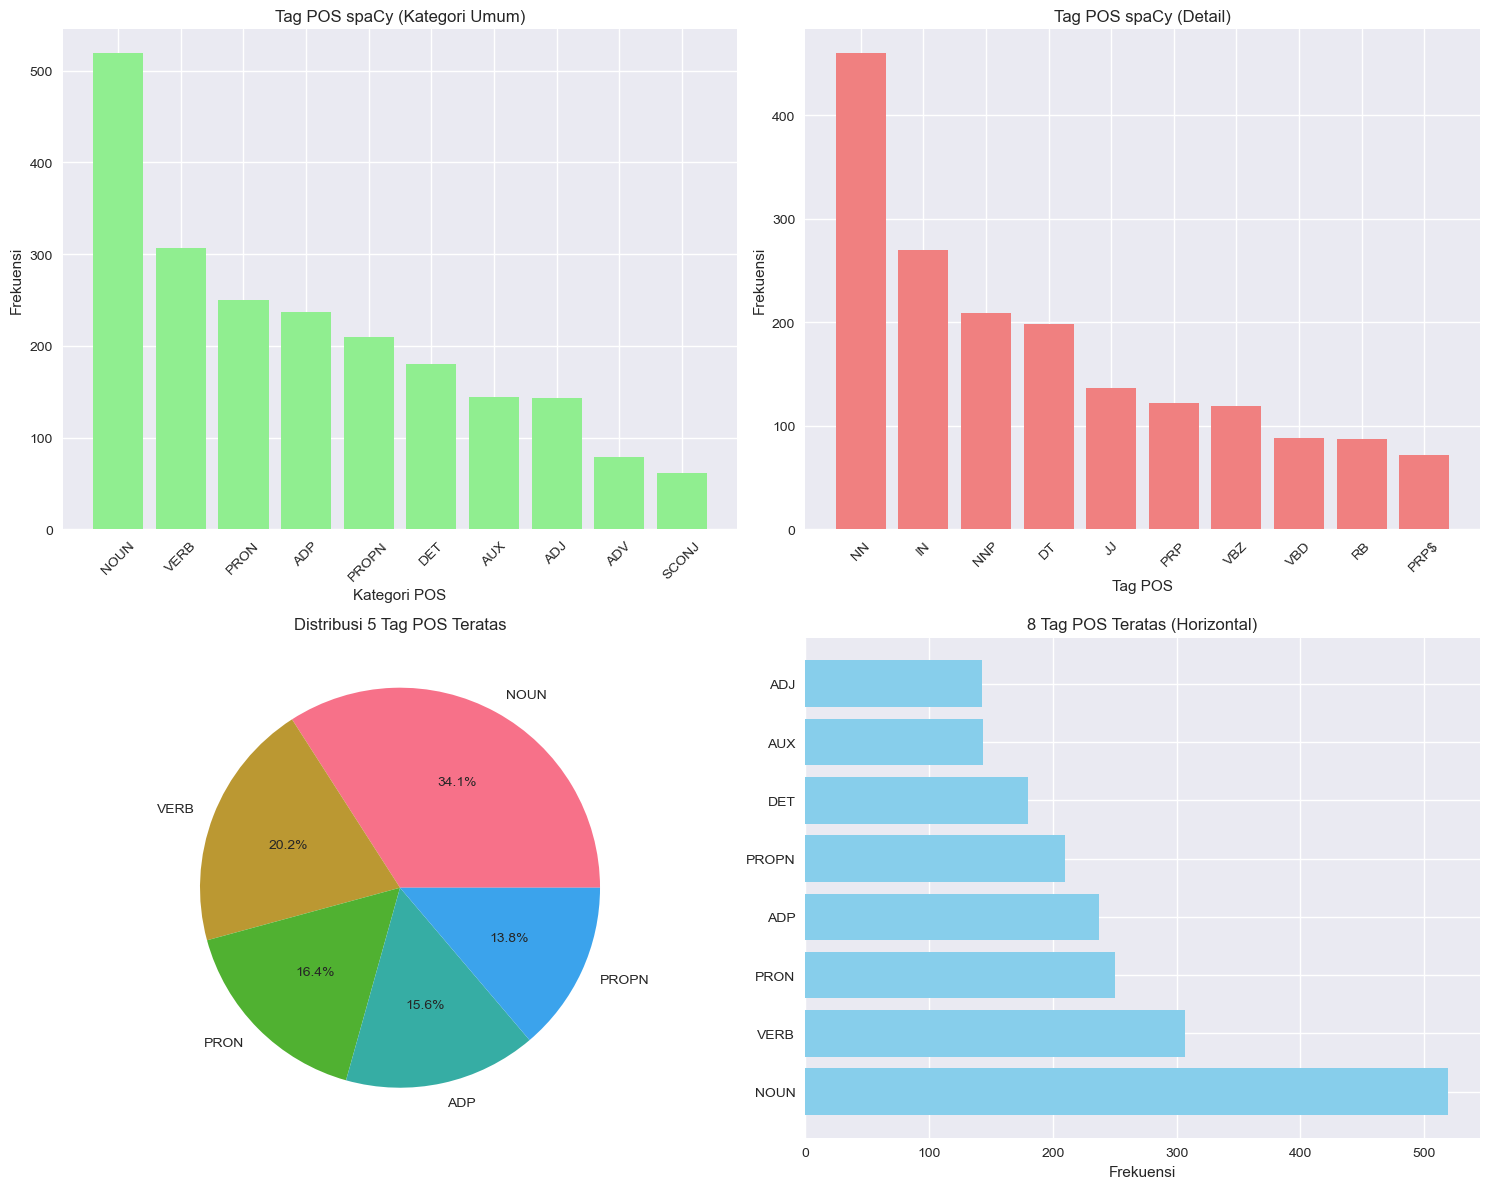

In [ ]:
if pos_analysis and pos_analysis['spacy_pos']:
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    spacy_broad_data = pos_analysis['spacy_pos'].most_common(10)
    categories, counts = zip(*spacy_broad_data)
    axes[0,0].bar(categories, counts, color='lightgreen')
    axes[0,0].set_title('Tag POS spaCy (Kategori Umum)')
    axes[0,0].set_xlabel('Kategori POS')
    axes[0,0].set_ylabel('Frekuensi')
    axes[0,0].tick_params(axis='x', rotation=45)

    spacy_detailed_data = pos_analysis['spacy_detailed'].most_common(10)
    tags, counts = zip(*spacy_detailed_data)
    axes[0,1].bar(tags, counts, color='lightcoral')
    axes[0,1].set_title('Tag POS spaCy (Detail)')
    axes[0,1].set_xlabel('Tag POS')
    axes[0,1].set_ylabel('Frekuensi')
    axes[0,1].tick_params(axis='x', rotation=45)

    top_5_spacy = dict(pos_analysis['spacy_pos'].most_common(5))
    axes[1,0].pie(top_5_spacy.values(), labels=top_5_spacy.keys(), autopct='%1.1f%%')
    axes[1,0].set_title('Distribusi 5 Tag POS Teratas')

    spacy_top_8 = pos_analysis['spacy_pos'].most_common(8)
    tags, counts = zip(*spacy_top_8)
    axes[1,1].barh(tags, counts, color='skyblue')
    axes[1,1].set_title('8 Tag POS Teratas (Horizontal)')
    axes[1,1].set_xlabel('Frekuensi')
    
    plt.tight_layout()
    plt.show()
else:
    print("Tidak ada data untuk visualisasi")

## 8. Analisis Pola Struktur Kalimat

=== Pola Kalimat Paling Umum (6 Tag POS Pertama) ===
PRON-V-PRON-N-LAIN: 2 kali
N-V-V-N-PREP-N: 1 kali
PRON-V-LAIN-ADJ-CONJ-PRON: 1 kali
N-PRON-V-CONJ-V-PRON: 1 kali
N-LAIN-V-LAIN-V-DET: 1 kali
PRON-V-V-ADJ-PREP-ADV: 1 kali
N-CONJ-N-LAIN-V-PRON: 1 kali
N-V-NUM-LAIN: 1 kali
PRON-N-N-V-NUM-CONJ: 1 kali
DET-N-V-ADV-DET-ADJ: 1 kali


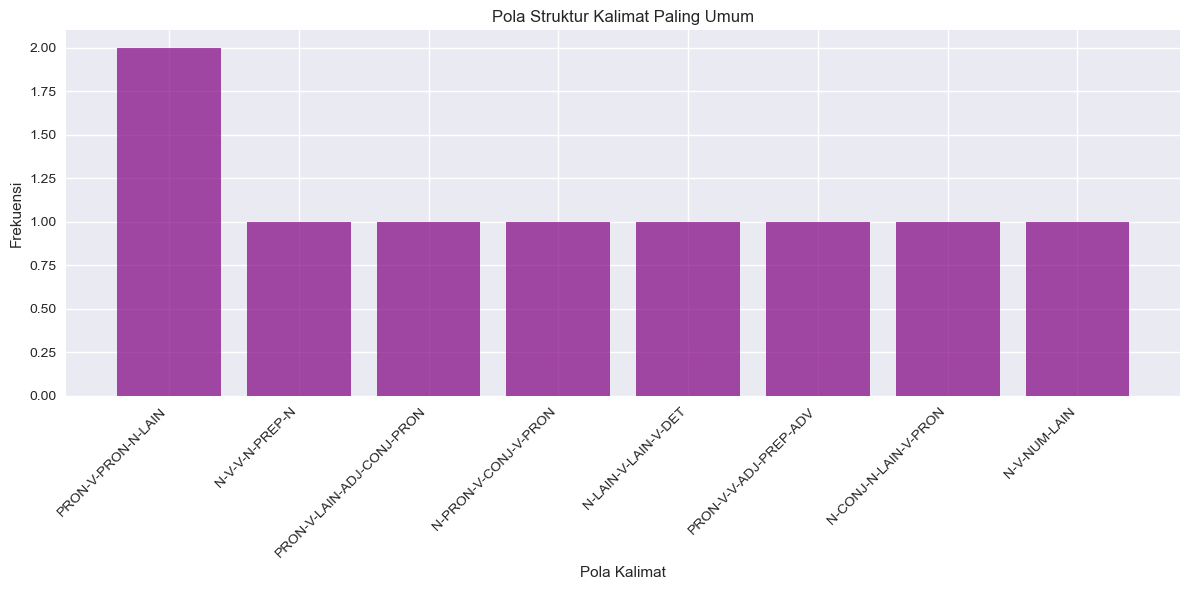

In [67]:
def analyze_sentence_patterns_spacy(pos_results):
    """
    Menganalisis pola struktur kalimat umum menggunakan spaCy
    """
    patterns = []
    pattern_counter = Counter()

    simple_mapping = {
        'NOUN': 'N', 'PROPN': 'N',
        'VERB': 'V', 'AUX': 'V',
        'ADJ': 'ADJ',
        'ADV': 'ADV',
        'PRON': 'PRON',
        'DET': 'DET',
        'ADP': 'PREP',
        'CCONJ': 'CONJ', 'SCONJ': 'CONJ',
        'NUM': 'NUM'
    }
    
    for result in pos_results:
        pattern = []
        for word, tag in result['pos_tags']:
            simple_tag = simple_mapping.get(tag, 'LAIN')
            pattern.append(simple_tag)

        if len(pattern) >= 3: 
            pattern_str = '-'.join(pattern[:6])
            pattern_counter[pattern_str] += 1
            patterns.append(pattern_str)
    
    return pattern_counter, patterns

if spacy_pos_results:
    pattern_counter, all_patterns = analyze_sentence_patterns_spacy(spacy_pos_results)
    
    print("=== Pola Kalimat Paling Umum (6 Tag POS Pertama) ===")
    for pattern, count in pattern_counter.most_common(10):
        print(f"{pattern}: {count} kali")

    if pattern_counter:
        plt.figure(figsize=(12, 6))
        top_patterns = pattern_counter.most_common(8)
        patterns, counts = zip(*top_patterns)
        plt.bar(range(len(patterns)), counts, color='purple', alpha=0.7)
        plt.xlabel('Pola Kalimat')
        plt.ylabel('Frekuensi')
        plt.title('Pola Struktur Kalimat Paling Umum')
        plt.xticks(range(len(patterns)), patterns, rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
else:
    print("Tidak ada analisis pola yang tersedia")
    pattern_counter = Counter()

## 9. Summary dan Insights

In [ ]:

def generate_summary_spacy(pos_analysis, pattern_counter):
    print("=== RINGKASAN ANALISIS POS TAGGING (spaCy) ===")
    print(f"\nTotal tweet yang dianalisis: {len(preprocessed_texts)}")
    print(f"Total kalimat yang diproses: {len(spacy_pos_results) if spacy_pos_results else 0}")
    
    if not pos_analysis or not pos_analysis['spacy_pos']:
        print("Tidak ada data analisis yang tersedia")
        return

    print("\n--- JENIS KATA YANG PALING SERING MUNCUL ---")
    top_3_spacy = pos_analysis['spacy_pos'].most_common(3)
    for i, (category, count) in enumerate(top_3_spacy, 1):
        total = sum(pos_analysis['spacy_pos'].values())
        percentage = (count / total) * 100
        print(f"{i}. {category}: {count} ({percentage:.1f}%)")

    if pattern_counter:
        print("\n--- POLA UMUM STRUKTUR KALIMAT ---")
        top_3_patterns = pattern_counter.most_common(3)
        for i, (pattern, count) in enumerate(top_3_patterns, 1):
            print(f"{i}. {pattern}: {count} kali")

    print("\n--- WAWASAN ---")

    pos_counts = dict(pos_analysis['spacy_pos'])
    noun_count = pos_counts.get('NOUN', 0) + pos_counts.get('PROPN', 0)
    verb_count = pos_counts.get('VERB', 0) + pos_counts.get('AUX', 0)
    adj_count = pos_counts.get('ADJ', 0)
    
    if noun_count > verb_count and noun_count > adj_count:
        print("• Tweet cenderung menggunakan banyak kata benda (NOUN/PROPN), menunjukkan fokus pada objek/subjek")
    elif verb_count > noun_count:
        print("• Tweet cenderung berorientasi aksi dengan banyak kata kerja (VERB/AUX)")

    if pattern_counter:
        most_common_pattern = pattern_counter.most_common(1)[0][0]
        if 'PRON' in most_common_pattern and 'V' in most_common_pattern:
            print("• Struktur kalimat umum: Subjek (Kata Ganti) + Kata Kerja, menunjukkan gaya informal")
        if 'N' in most_common_pattern and 'V' in most_common_pattern:
            print("• Struktur kalimat umum: Kata Benda + Kata Kerja, menunjukkan kalimat deklaratif")

    total_words = sum(pos_analysis['spacy_pos'].values())
    if spacy_pos_results:
        avg_words_per_sentence = total_words / len(spacy_pos_results)
        print(f"• Rata-rata {avg_words_per_sentence:.1f} kata per kalimat (karakteristik Twitter)")
    
    if pos_counts.get('PRON', 0) > pos_counts.get('DET', 0):
        print("• Penggunaan kata ganti tinggi menunjukkan sifat personal dan informal")

generate_summary_spacy(pos_analysis, pattern_counter)

=== RINGKASAN ANALISIS POS TAGGING (spaCy) ===

Total tweet yang dianalisis: 113
Total kalimat yang diproses: 52

--- JENIS KATA YANG PALING SERING MUNCUL ---
1. NOUN: 519 (22.7%)
2. VERB: 307 (13.4%)
3. PRON: 250 (10.9%)

--- POLA UMUM STRUKTUR KALIMAT ---
1. PRON-V-PRON-N-LAIN: 2 kali
2. N-V-V-N-PREP-N: 1 kali
3. PRON-V-LAIN-ADJ-CONJ-PRON: 1 kali

--- WAWASAN ---
• Tweet cenderung menggunakan banyak kata benda (NOUN/PROPN), menunjukkan fokus pada objek/subjek
• Struktur kalimat umum: Subjek (Kata Ganti) + Kata Kerja, menunjukkan gaya informal
• Struktur kalimat umum: Kata Benda + Kata Kerja, menunjukkan kalimat deklaratif
• Rata-rata 43.9 kata per kalimat (karakteristik Twitter)
• Penggunaan kata ganti tinggi menunjukkan sifat personal dan informal


## 11. Named Entity Recognition (NER) Analysis

In [ ]:
def perform_ner_analysis(texts, max_texts=10):
    """
    Melakukan Named Entity Recognition pada teks terpilih
    """
    if nlp is None:
        return []
    
    ner_results = []
    
    for i, text in enumerate(texts[:max_texts]):
        doc = nlp(text)
        
        entities = []
        for ent in doc.ents:
            entities.append({
                'text': ent.text,
                'label': ent.label_,
                'description': spacy.explain(ent.label_),
                'start': ent.start_char,
                'end': ent.end_char
            })
        
        ner_results.append({
            'paragraph_id': i + 1,
            'text': text,
            'entities': entities,
            'entity_count': len(entities)
        })
    
    return ner_results

ner_results = perform_ner_analysis(preprocessed_texts)

print(f"Analisis NER selesai pada {len(ner_results)} paragraf")
print(f"Total entitas ditemukan: {sum([result['entity_count'] for result in ner_results])}")

Analisis NER selesai pada 10 paragraf
Total entitas ditemukan: 13


## 12. Visualisasi Entitas dengan Tabel

In [ ]:
def create_ner_table(ner_results):
    """
    Membuat tabel komprehensif dari semua entitas yang teridentifikasi
    """
    table_data = []
    
    for result in ner_results:
        paragraph_text = result['text'][:100] + '...' if len(result['text']) > 100 else result['text']
        
        if result['entities']:
            for entity in result['entities']:
                table_data.append({
                    'ID_Paragraf': result['paragraph_id'],
                    'Teks_Paragraf': paragraph_text,
                    'Teks_Entitas': entity['text'],
                    'Jenis_Entitas': entity['label'],
                    'Deskripsi': entity['description'],
                    'Posisi': f"{entity['start']}-{entity['end']}"
                })
        else:
            table_data.append({
                'ID_Paragraf': result['paragraph_id'],
                'Teks_Paragraf': paragraph_text,
                'Teks_Entitas': 'Tidak ada entitas ditemukan',
                'Jenis_Entitas': '-',
                'Deskripsi': '-',
                'Posisi': '-'
            })
    
    return pd.DataFrame(table_data)

ner_table = create_ner_table(ner_results)
print("=== Hasil Named Entity Recognition ===")
display(ner_table)

print("\n=== Ringkasan per Paragraf ===")
for result in ner_results:
    print(f"Paragraf {result['paragraph_id']}: {result['entity_count']} entitas")
    if result['entities']:
        entity_types = [ent['label'] for ent in result['entities']]
        print(f"  Jenis: {', '.join(set(entity_types))}")
    print()

=== Hasil Named Entity Recognition ===


,ID_Paragraf,Teks_Paragraf,Teks_Entitas,Jenis_Entitas,Deskripsi,Posisi
0,1,people will get lots of jokes off about macron...,Tidak ada entitas ditemukan,-,-,-
1,2,amerix: dont marry a woman older than you. it ...,first,ORDINAL,"""first"", ""second"", etc.",69-74
2,2,amerix: dont marry a woman older than you. it ...,macron,PERSON,"People, including fictional",174-180
3,3,macron was 15. his teacher brigette was 40 and...,macron,PERSON,"People, including fictional",0-6
4,3,macron was 15. his teacher brigette was 40 and...,15,DATE,Absolute or relative dates or periods,11-13
5,3,macron was 15. his teacher brigette was 40 and...,40,DATE,Absolute or relative dates or periods,40-42
6,3,macron was 15. his teacher brigette was 40 and...,18 year old,DATE,Absolute or relative dates or periods,63-74
7,4,macrons office claims that it was a moment of ...,macrons,ORG,"Companies, agencies, institutions, etc.",0-7
8,5,the puppet president of france emmanuel macron...,france,GPE,"Countries, cities, states",24-30
9,5,the puppet president of france emmanuel macron...,emmanuel macron,PERSON,"People, including fictional",31-46



=== Ringkasan per Paragraf ===
Paragraf 1: 0 entitas

Paragraf 2: 2 entitas
  Jenis: ORDINAL, PERSON

Paragraf 3: 4 entitas
  Jenis: PERSON, DATE

Paragraf 4: 1 entitas
  Jenis: ORG

Paragraf 5: 2 entitas
  Jenis: GPE, PERSON

Paragraf 6: 0 entitas

Paragraf 7: 1 entitas
  Jenis: CARDINAL

Paragraf 8: 0 entitas

Paragraf 9: 1 entitas
  Jenis: PERSON

Paragraf 10: 2 entitas
  Jenis: CARDINAL, PERSON



## 13. Analisis Frekuensi Entitas

In [ ]:
def analyze_entity_frequencies(ner_results):
    """
    Menganalisis frekuensi berbagai jenis entitas dan entitas spesifik
    """
    entity_type_counter = Counter()
    entity_text_counter = Counter()
    
    for result in ner_results:
        for entity in result['entities']:
            entity_type_counter[entity['label']] += 1
            # Normalize entity text for better counting
            normalized_text = entity['text'].lower().strip()
            entity_text_counter[normalized_text] += 1
    
    return entity_type_counter, entity_text_counter

# Perform frequency analysis
entity_type_freq, entity_text_freq = analyze_entity_frequencies(ner_results)

print("=== Jenis Entitas Paling Umum ===")
for entity_type, count in entity_type_freq.most_common(10):
    description = spacy.explain(entity_type)
    print(f"{entity_type} ({description}): {count}")

print("\n=== Entitas Spesifik Paling Umum ===")
for entity_text, count in entity_text_freq.most_common(15):
    print(f"'{entity_text}': {count}")

=== Jenis Entitas Paling Umum ===
PERSON (People, including fictional): 5
DATE (Absolute or relative dates or periods): 3
CARDINAL (Numerals that do not fall under another type): 2
ORDINAL ("first", "second", etc.): 1
ORG (Companies, agencies, institutions, etc.): 1
GPE (Countries, cities, states): 1

=== Entitas Spesifik Paling Umum ===
'macron': 2
'first': 1
'15': 1
'40': 1
'18 year old': 1
'macrons': 1
'france': 1
'emmanuel macron': 1
'14': 1
'macron blink': 1
'zelensky': 1
'one': 1


## 14. Visualisasi NER dengan Grafik

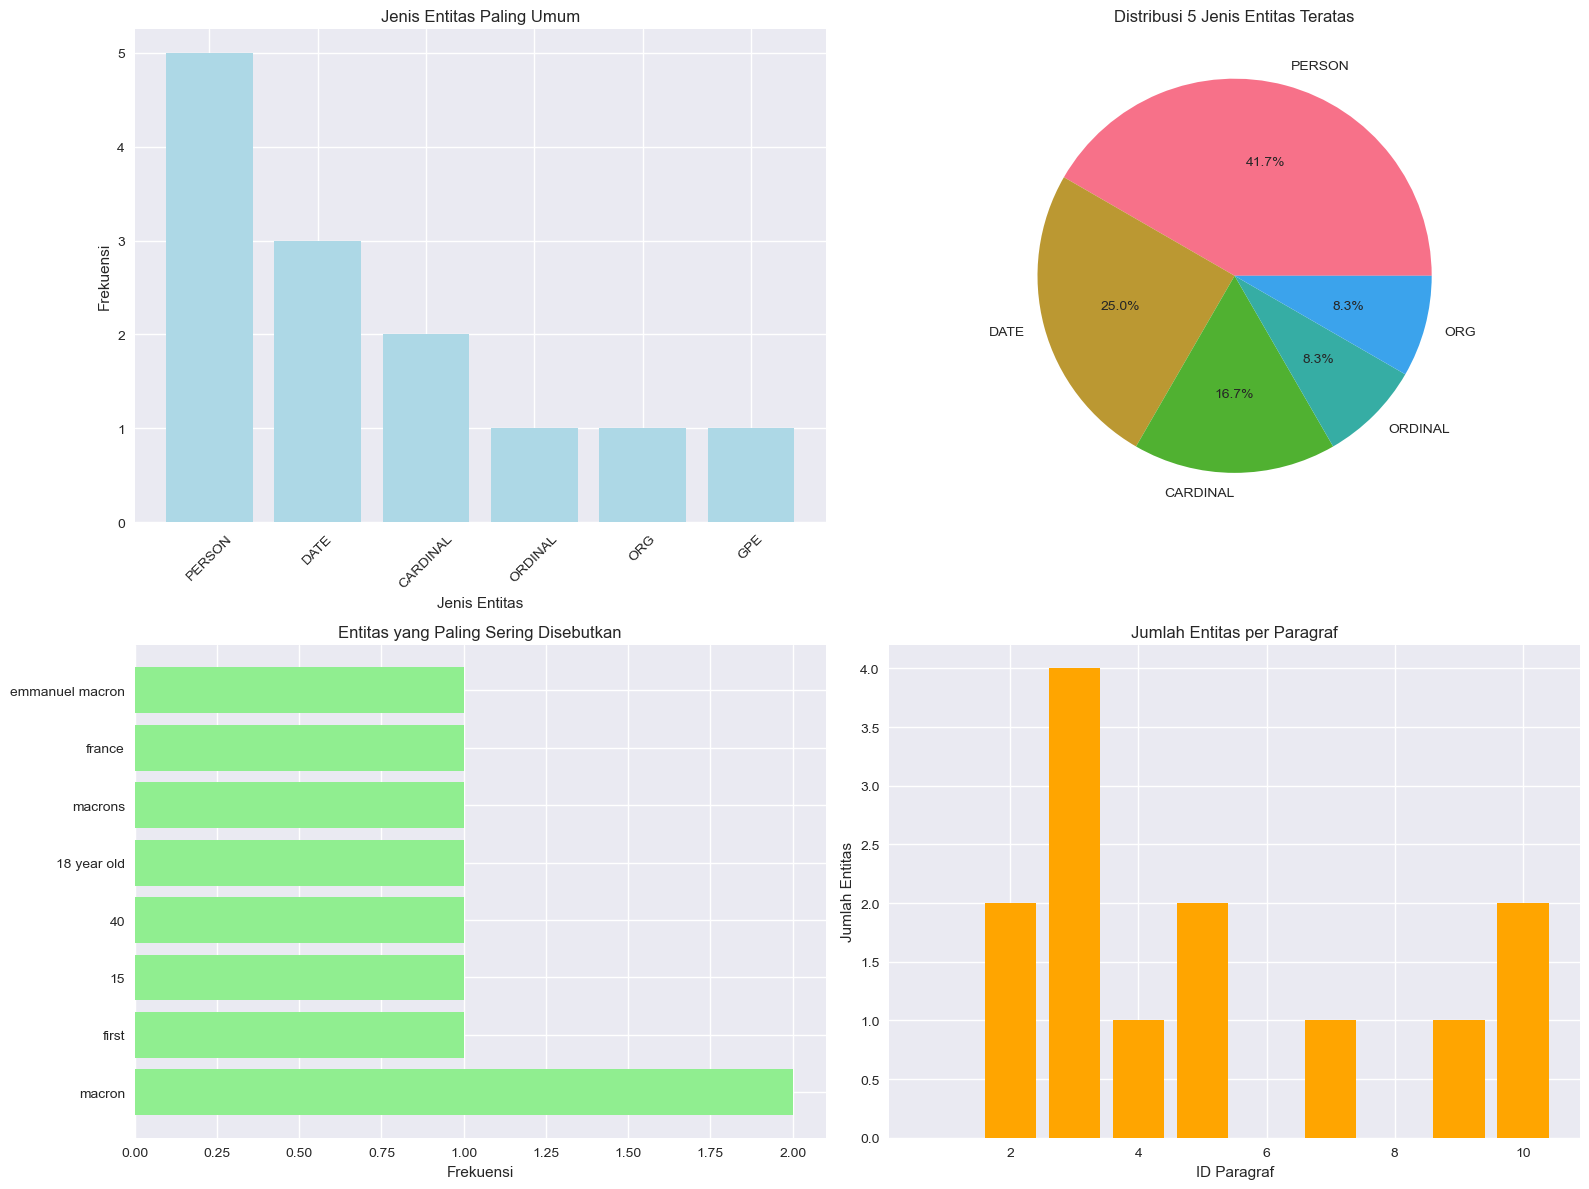

In [ ]:
if entity_type_freq:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    if entity_type_freq:
        types, counts = zip(*entity_type_freq.most_common(8))
        axes[0,0].bar(types, counts, color='lightblue')
        axes[0,0].set_title('Jenis Entitas Paling Umum')
        axes[0,0].set_xlabel('Jenis Entitas')
        axes[0,0].set_ylabel('Frekuensi')
        axes[0,0].tick_params(axis='x', rotation=45)

    if len(entity_type_freq) > 0:
        top_5_entities = dict(entity_type_freq.most_common(5))
        axes[0,1].pie(top_5_entities.values(), labels=top_5_entities.keys(), autopct='%1.1f%%')
        axes[0,1].set_title('Distribusi 5 Jenis Entitas Teratas')

    if entity_text_freq:
        top_entities = entity_text_freq.most_common(8)
        entities, counts = zip(*top_entities)
        truncated_entities = [ent[:15] + '...' if len(ent) > 15 else ent for ent in entities]
        axes[1,0].barh(truncated_entities, counts, color='lightgreen')
        axes[1,0].set_title('Entitas yang Paling Sering Disebutkan')
        axes[1,0].set_xlabel('Frekuensi')

    paragraph_ids = [result['paragraph_id'] for result in ner_results]
    entity_counts = [result['entity_count'] for result in ner_results]
    axes[1,1].bar(paragraph_ids, entity_counts, color='orange')
    axes[1,1].set_title('Jumlah Entitas per Paragraf')
    axes[1,1].set_xlabel('ID Paragraf')
    axes[1,1].set_ylabel('Jumlah Entitas')
    
    plt.tight_layout()
    plt.show()
else:
    print("Tidak ada entitas ditemukan untuk visualisasi")

## 15. Analisis Kontekstual Entitas

In [ ]:
def analyze_entity_context(ner_results):
    """
    Menganalisis entitas dalam konteks dataset Macron
    """
    print("=== ANALISIS KONTEKSTUAL ENTITAS ===")

    entity_type_freq, entity_text_freq = analyze_entity_frequencies(ner_results)

    persons = []
    organizations = []
    locations = []
    dates = []
    
    for result in ner_results:
        for entity in result['entities']:
            entity_text = entity['text'].lower().strip()
            if entity['label'] == 'PERSON':
                persons.append(entity_text)
            elif entity['label'] == 'ORG':
                organizations.append(entity_text)
            elif entity['label'] in ['GPE', 'LOC']:
                locations.append(entity_text)
            elif entity['label'] == 'DATE':
                dates.append(entity_text)
    
    print(f"\n--- ANALISIS BERDASARKAN TIPE ENTITAS ---")
    print(f"Total entitas ditemukan: {sum(entity_type_freq.values())}")
    print(f"Tipe entitas unik: {len(entity_type_freq)}")
    
    if persons:
        person_counter = Counter(persons)
        print(f"\nEntitas PERSON ({len(persons)} total):")
        for person, count in person_counter.most_common(5):
            print(f"  • {person}: {count} kali")
    
    if organizations:
        org_counter = Counter(organizations)
        print(f"\nEntitas ORG ({len(organizations)} total):")
        for org, count in org_counter.most_common(5):
            print(f"  • {org}: {count} kali")
    
    if locations:
        loc_counter = Counter(locations)
        print(f"\nEntitas LOKASI ({len(locations)} total):")
        for loc, count in loc_counter.most_common(5):
            print(f"  • {loc}: {count} kali")

    print(f"\n--- WAWASAN KONTEKSTUAL ---")

    macron_mentions = entity_text_freq.get('macron', 0) + entity_text_freq.get('emmanuel macron', 0)
    if macron_mentions > 0:
        print(f"• Macron disebutkan {macron_mentions} kali sebagai entitas bernama")

    political_entities = ['france', 'french', 'president', 'ukraine', 'zelensky']
    political_count = sum([entity_text_freq.get(ent, 0) for ent in political_entities])
    if political_count > 0:
        print(f"• Entitas politik ditemukan {political_count} kali, menunjukkan konteks politik yang kuat")

    age_numbers = [ent for ent in entity_text_freq.keys() if any(age in ent for age in ['15', '40', '47', '72'])]
    if age_numbers:
        print(f"• Angka usia ditemukan: {age_numbers[:3]}, relevan dengan kontroversi usia Macron dan istri")

    if len(entity_type_freq) >= 3:
        print(f"• Dataset menunjukkan keragaman entitas ({len(entity_type_freq)} tipe), mencerminkan kompleksitas topik")

    if entity_type_freq:
        most_common_type = entity_type_freq.most_common(1)[0]
        print(f"• Tipe entitas dominan: {most_common_type[0]} ({spacy.explain(most_common_type[0])}) dengan {most_common_type[1]} kemunculan")

analyze_entity_context(ner_results)

=== ANALISIS KONTEKSTUAL ENTITAS ===

--- ANALISIS BERDASARKAN TIPE ENTITAS ---
Total entitas ditemukan: 13
Tipe entitas unik: 6

Entitas PERSON (5 total):
  • macron: 2 kali
  • emmanuel macron: 1 kali
  • macron blink: 1 kali
  • zelensky: 1 kali

Entitas ORG (1 total):
  • macrons: 1 kali

Entitas LOKASI (1 total):
  • france: 1 kali

--- WAWASAN KONTEKSTUAL ---
• Macron disebutkan 3 kali sebagai entitas bernama
• Entitas politik ditemukan 2 kali, menunjukkan konteks politik yang kuat
• Angka usia ditemukan: ['15', '40'], relevan dengan kontroversi usia Macron dan istri
• Dataset menunjukkan keragaman entitas (6 tipe), mencerminkan kompleksitas topik
• Tipe entitas dominan: PERSON (People, including fictional) dengan 5 kemunculan


## 16. Word Embeddings dengan Word2Vec

In [ ]:
%pip install gensim scikit-learn
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np
from nltk.tokenize import word_tokenize

def prepare_word2vec_data(texts):
    """
    Menyiapkan kalimat yang telah ditokenisasi untuk pelatihan Word2Vec
    """
    sentences = []
    
    for text in texts:
        if nlp is not None:
            doc = nlp(text)
            tokens = [token.text.lower() for token in doc 
                     if not token.is_punct and not token.is_space and len(token.text) > 1]
            if len(tokens) > 2: 
                sentences.append(tokens)
        else:
            tokens = word_tokenize(text.lower())
            tokens = [token for token in tokens if token.isalpha() and len(token) > 1]
            if len(tokens) > 2:
                sentences.append(tokens)
    
    return sentences

word2vec_sentences = prepare_word2vec_data(preprocessed_texts)
print(f"Menyiapkan {len(word2vec_sentences)} kalimat untuk pelatihan Word2Vec")
print(f"Contoh kalimat: {word2vec_sentences[0] if word2vec_sentences else 'Tidak ada kalimat tersedia'}")


Menyiapkan 110 kalimat untuk pelatihan Word2Vec
Contoh kalimat: ['people', 'will', 'get', 'lots', 'of', 'jokes', 'off', 'about', 'macron', 'getting', 'slapped', 'by', 'his', 'wife', 'but', 'real', 'talk', 'if', 'you', 're', 'in', 'relationship', 'where', 'someone', 'puts', 'hands', 'on', 'you', 'leave', 'it', 'not', 'normal', 'and', 'there', 'no', 'excuse', 'for', 'it', 'people', 'who', 'love', 'and', 'respect', 'you', 'don', 'hit', 'you']
Menyiapkan 110 kalimat untuk pelatihan Word2Vec
Contoh kalimat: ['people', 'will', 'get', 'lots', 'of', 'jokes', 'off', 'about', 'macron', 'getting', 'slapped', 'by', 'his', 'wife', 'but', 'real', 'talk', 'if', 'you', 're', 'in', 'relationship', 'where', 'someone', 'puts', 'hands', 'on', 'you', 'leave', 'it', 'not', 'normal', 'and', 'there', 'no', 'excuse', 'for', 'it', 'people', 'who', 'love', 'and', 'respect', 'you', 'don', 'hit', 'you']


In [68]:

def train_word2vec_model(sentences, vector_size=100, window=5, min_count=2, workers=4):
    """
    Melatih model Word2Vec pada kalimat yang telah disiapkan
    """
    if not sentences:
        print("Tidak ada kalimat tersedia untuk pelatihan")
        return None

    model = Word2Vec(
        sentences=sentences,
        vector_size=vector_size,
        window=window,
        min_count=min_count,
        workers=workers,
        sg=0,  # CBOW
        epochs=20
    )
    
    return model

w2v_model = train_word2vec_model(word2vec_sentences)

if w2v_model:
    print(f"Model Word2Vec berhasil dilatih!")
    print(f"Ukuran vocabulary: {len(w2v_model.wv.key_to_index)}")
    print(f"Dimensi vektor: {w2v_model.vector_size}")

    vocab_words = list(w2v_model.wv.key_to_index.keys())
    print(f"Contoh vocabulary: {vocab_words[:20]}")
else:
    print("Gagal melatih model Word2Vec")

Model Word2Vec berhasil dilatih!
Ukuran vocabulary: 275
Dimensi vektor: 100
Contoh vocabulary: ['macron', 'the', 'his', 'in', 'and', 'is', 'emmanuel', 'wife', 'of', 'brigitte', 'to', 'by', 'president', 'he', 'was', 'face', 'slapped', 'that', 'it', 'this']


## 17. Eksplorasi Kata Serupa

In [ ]:
def explore_similar_words(model, target_words, topn=10):
    """
    Mencari kata-kata yang serupa dengan kata target dalam model Word2Vec
    """
    if not model:
        print("Tidak ada model tersedia")
        return
    
    results = {}
    
    for word in target_words:
        if word in model.wv.key_to_index:
            try:
                similar_words = model.wv.most_similar(word, topn=topn)
                results[word] = similar_words
                print(f"\n=== Kata yang paling mirip dengan '{word}' ===")
                for similar_word, similarity in similar_words:
                    print(f"  {similar_word}: {similarity:.4f}")
            except Exception as e:
                print(f"Error mencari kata serupa untuk '{word}': {e}")
        else:
            print(f"'{word}' tidak ditemukan dalam vocabulary")
    
    return results

target_words = [
    'macron', 'france', 'president', 'wife', 'brigitte',
    'emmanuel', 'political', 'domestic', 'violence', 'husband'
]

similar_words_results = explore_similar_words(w2v_model, target_words, topn=8)


=== Kata yang paling mirip dengan 'macron' ===
  the: 0.9996
  to: 0.9996
  and: 0.9996
  of: 0.9996
  if: 0.9996
  you: 0.9995
  his: 0.9995
  is: 0.9995

=== Kata yang paling mirip dengan 'france' ===
  his: 0.9986
  macron: 0.9985
  to: 0.9985
  in: 0.9984
  him: 0.9984
  and: 0.9984
  with: 0.9984
  the: 0.9984

=== Kata yang paling mirip dengan 'president' ===
  and: 0.9993
  macron: 0.9993
  to: 0.9992
  the: 0.9992
  his: 0.9992
  was: 0.9992
  but: 0.9992
  are: 0.9991

=== Kata yang paling mirip dengan 'wife' ===
  this: 0.9995
  macron: 0.9995
  to: 0.9995
  and: 0.9994
  that: 0.9994
  was: 0.9994
  the: 0.9994
  his: 0.9994

=== Kata yang paling mirip dengan 'brigitte' ===
  macron: 0.9995
  of: 0.9994
  to: 0.9994
  the: 0.9993
  his: 0.9993
  if: 0.9993
  and: 0.9993
  is: 0.9993

=== Kata yang paling mirip dengan 'emmanuel' ===
  if: 0.9995
  his: 0.9995
  and: 0.9994
  macron: 0.9994
  to: 0.9994
  but: 0.9994
  the: 0.9994
  is: 0.9994
'political' tidak ditemukan dala

In [69]:
def analyze_word_relationships(model, word_pairs):
    """
    Menganalisis hubungan semantik antara pasangan kata
    """
    if not model:
        return
    
    print("=== ANALISIS HUBUNGAN SEMANTIK ===")
    
    for word1, word2 in word_pairs:
        if word1 in model.wv.key_to_index and word2 in model.wv.key_to_index:
            similarity = model.wv.similarity(word1, word2)
            print(f"Kemiripan antara '{word1}' dan '{word2}': {similarity:.4f}")
        else:
            missing = []
            if word1 not in model.wv.key_to_index:
                missing.append(word1)
            if word2 not in model.wv.key_to_index:
                missing.append(word2)
            print(f"Kata tidak ada dalam vocabulary: {missing}")

word_pairs = [
    ('macron', 'emmanuel'),
    ('macron', 'president'),
    ('brigitte', 'wife'),
    ('france', 'french'),
    ('domestic', 'violence'),
    ('husband', 'wife'),
    ('slapped', 'hit'),
    ('political', 'president')
]

analyze_word_relationships(w2v_model, word_pairs)

=== ANALISIS HUBUNGAN SEMANTIK ===
Kemiripan antara 'macron' dan 'emmanuel': 0.9994
Kemiripan antara 'macron' dan 'president': 0.9993
Kemiripan antara 'brigitte' dan 'wife': 0.9991
Kemiripan antara 'france' dan 'french': 0.9981
Kemiripan antara 'domestic' dan 'violence': 0.9930
Kemiripan antara 'husband' dan 'wife': 0.9991
Kemiripan antara 'slapped' dan 'hit': 0.9972
Kata tidak ada dalam vocabulary: ['political']


## 18. Visualisasi Word Embeddings dengan t-SNE dan PCA

In [ ]:
def prepare_visualization_data(model, top_n_words=50):
    """
    Menyiapkan vektor kata untuk visualisasi
    """
    if not model:
        return None, None

    vocab_freq = [(word, model.wv.get_vecattr(word, "count")) 
                  for word in model.wv.key_to_index.keys()]
    vocab_freq.sort(key=lambda x: x[1], reverse=True)

    selected_words = [word for word, freq in vocab_freq[:top_n_words]]

    word_vectors = np.array([model.wv[word] for word in selected_words])
    
    return selected_words, word_vectors

viz_words, viz_vectors = prepare_visualization_data(w2v_model, top_n_words=40)

if viz_words is not None and viz_vectors is not None:
    print(f"Menyiapkan {len(viz_words)} kata untuk visualisasi")
    print(f"Kata terpilih: {viz_words[:15]}...")
else:
    print("Tidak dapat menyiapkan data visualisasi")

Menyiapkan 40 kata untuk visualisasi
Kata terpilih: ['macron', 'the', 'his', 'in', 'and', 'is', 'emmanuel', 'wife', 'of', 'brigitte', 'to', 'by', 'president', 'he', 'was']...


Menerapkan t-SNE...
Menerapkan PCA...
Menerapkan PCA...


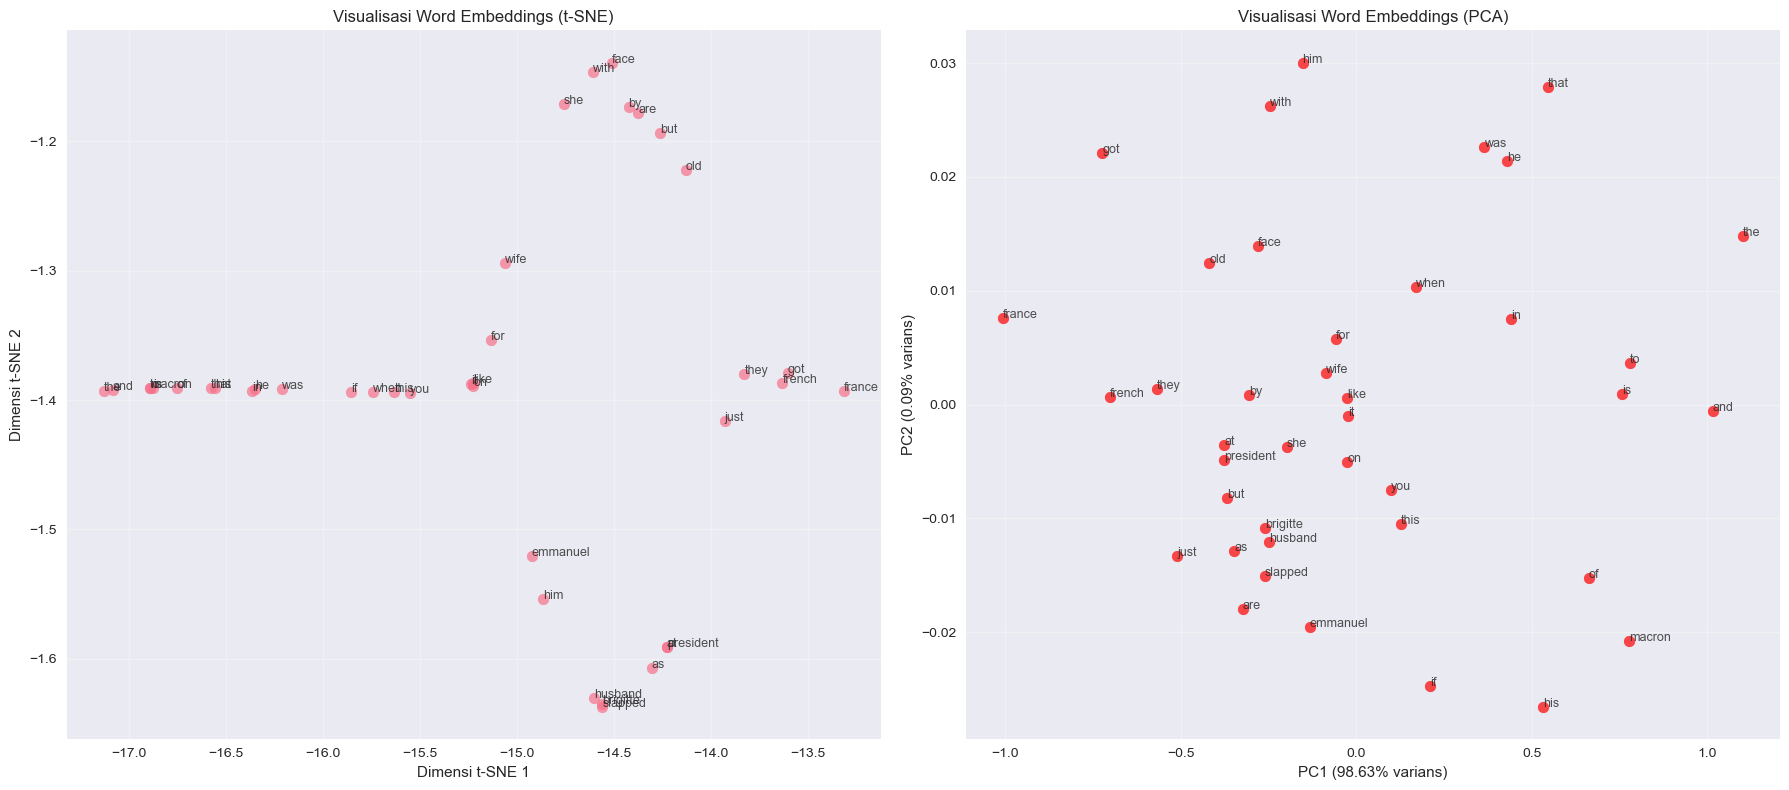

In [ ]:
def create_embedding_visualizations(words, vectors):
    """
    Membuat visualisasi t-SNE dan PCA dari word embeddings
    """
    if words is None or vectors is None:
        print("Tidak ada data tersedia untuk visualisasi")
        return

    print("Menerapkan t-SNE...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(words)-1))
    tsne_coords = tsne.fit_transform(vectors)
    
    print("Menerapkan PCA...")
    pca = PCA(n_components=2, random_state=42)
    pca_coords = pca.fit_transform(vectors)

    fig, axes = plt.subplots(1, 2, figsize=(18, 8))

    axes[0].scatter(tsne_coords[:, 0], tsne_coords[:, 1], alpha=0.7, s=60)
    for i, word in enumerate(words):
        axes[0].annotate(word, (tsne_coords[i, 0], tsne_coords[i, 1]), 
                        fontsize=9, alpha=0.8)
    axes[0].set_title('Visualisasi Word Embeddings (t-SNE)')
    axes[0].set_xlabel('Dimensi t-SNE 1')
    axes[0].set_ylabel('Dimensi t-SNE 2')
    axes[0].grid(True, alpha=0.3)

    axes[1].scatter(pca_coords[:, 0], pca_coords[:, 1], alpha=0.7, s=60, color='red')
    for i, word in enumerate(words):
        axes[1].annotate(word, (pca_coords[i, 0], pca_coords[i, 1]), 
                        fontsize=9, alpha=0.8)
    axes[1].set_title('Visualisasi Word Embeddings (PCA)')
    axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} varians)')
    axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} varians)')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return tsne_coords, pca_coords

tsne_result, pca_result = create_embedding_visualizations(viz_words, viz_vectors)

## 19. Export Results

In [ ]:
# Export results to CSV for further analysis
if spacy_pos_results:
    results_df = pd.DataFrame({
        'Kalimat': [r['sentence'] for r in spacy_pos_results[:30]],
        'Jumlah_Kata': [len(r['words']) for r in spacy_pos_results[:30]],
        'Tag_POS': [str(r['pos_tags']) for r in spacy_pos_results[:30]],
        'Tag_Detail': [str(r['detailed_tags']) for r in spacy_pos_results[:30]]
    })
    
    results_df.to_csv('hasil_pos_tagging_spacy.csv', index=False)
    print("Hasil disimpan ke 'hasil_pos_tagging_spacy.csv'")

# Export frequency analysis
if pos_analysis and pos_analysis['spacy_pos']:
    freq_df = pd.DataFrame([
        {'Kategori_POS': cat, 'Frekuensi': freq, 'Persentase': (freq/sum(pos_analysis['spacy_pos'].values()))*100}
        for cat, freq in pos_analysis['spacy_pos'].most_common()
    ])
    
    freq_df.to_csv('analisis_frekuensi_pos_spacy.csv', index=False)
    print("Analisis frekuensi disimpan ke 'analisis_frekuensi_pos_spacy.csv'")
    
    # Export detailed tags analysis
    detailed_freq_df = pd.DataFrame([
        {'Tag_POS_Detail': tag, 'Frekuensi': freq, 'Persentase': (freq/sum(pos_analysis['spacy_detailed'].values()))*100}
        for tag, freq in pos_analysis['spacy_detailed'].most_common()
    ])
    
    detailed_freq_df.to_csv('analisis_pos_detail_spacy.csv', index=False)
    print("Analisis POS detail disimpan ke 'analisis_pos_detail_spacy.csv'")

# Export NER results
if ner_results:
    # Export detailed NER table
    ner_table.to_csv('hasil_analisis_ner.csv', index=False)
    print("Hasil NER disimpan ke 'hasil_analisis_ner.csv'")
    
    # Export entity frequency analysis
    entity_freq_df = pd.DataFrame([
        {'Jenis_Entitas': etype, 'Frekuensi': freq, 'Deskripsi': spacy.explain(etype)}
        for etype, freq in entity_type_freq.most_common()
    ])
    entity_freq_df.to_csv('frekuensi_jenis_entitas.csv', index=False)
    print("Frekuensi jenis entitas disimpan ke 'frekuensi_jenis_entitas.csv'")
    
    # Export specific entity frequency
    specific_entity_df = pd.DataFrame([
        {'Teks_Entitas': etext, 'Frekuensi': freq}
        for etext, freq in entity_text_freq.most_common(20)
    ])
    specific_entity_df.to_csv('frekuensi_entitas_spesifik.csv', index=False)
    print("Frekuensi entitas spesifik disimpan ke 'frekuensi_entitas_spesifik.csv'")

    summary_stats = {
        'Total_Paragraf_Dianalisis': len(ner_results),
        'Total_Entitas_Ditemukan': sum([result['entity_count'] for result in ner_results]),
        'Jenis_Entitas_Unik': len(entity_type_freq),
        'Entitas_Unik': len(entity_text_freq),
        'Jenis_Entitas_Tersering': entity_type_freq.most_common(1)[0][0] if entity_type_freq else 'Tidak Ada',
        'Entitas_Tersering': entity_text_freq.most_common(1)[0][0] if entity_text_freq else 'Tidak Ada'
    }
    
    summary_df = pd.DataFrame([summary_stats])
    summary_df.to_csv('statistik_ringkasan_ner.csv', index=False)
    print("Statistik ringkasan disimpan ke 'statistik_ringkasan_ner.csv'")
    
    print(f"\n=== RINGKASAN ANALISIS NER ===")
    for key, value in summary_stats.items():
        print(f"{key.replace('_', ' ')}: {value}")
else:
    print("Tidak ada hasil NER untuk diekspor")

Hasil disimpan ke 'hasil_pos_tagging_spacy.csv'
Analisis frekuensi disimpan ke 'analisis_frekuensi_pos_spacy.csv'
Analisis POS detail disimpan ke 'analisis_pos_detail_spacy.csv'
Hasil NER disimpan ke 'hasil_analisis_ner.csv'
Frekuensi jenis entitas disimpan ke 'frekuensi_jenis_entitas.csv'
Frekuensi entitas spesifik disimpan ke 'frekuensi_entitas_spesifik.csv'
Statistik ringkasan disimpan ke 'statistik_ringkasan_ner.csv'

=== RINGKASAN ANALISIS NER ===
Total Paragraf Dianalisis: 10
Total Entitas Ditemukan: 13
Jenis Entitas Unik: 6
Entitas Unik: 12
Jenis Entitas Tersering: PERSON
Entitas Tersering: macron
